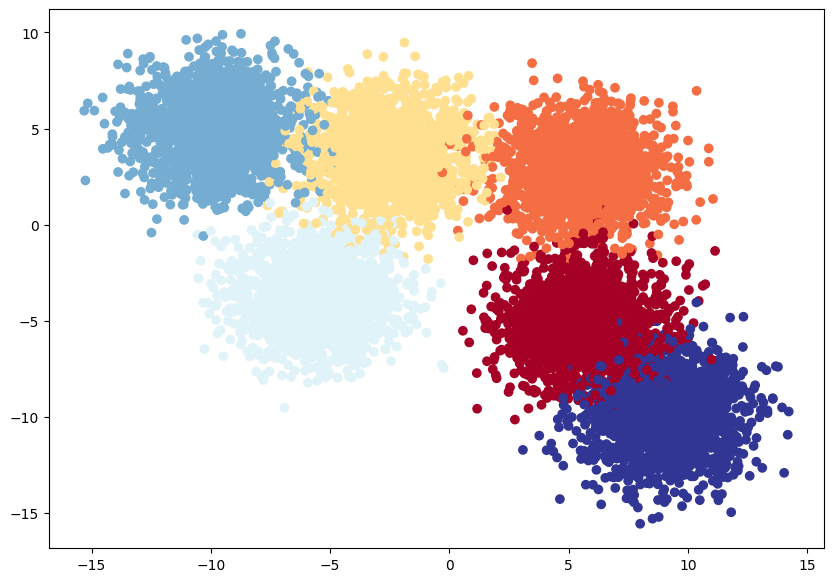

In [ ]:
import torch as tr
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#HYPERPARAMETERS FOR DATASET

NUM_CLASSES = 6
NUM_FEATURES = 7
RANDOM_SEED = 13

#create multi class data

X_blob, y_blob = make_blobs(n_samples = 10000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std=1.7,
                            random_state = RANDOM_SEED)

#turn data into tensors

X_blob = tr.from_numpy(X_blob).type(tr.float32)
y_blob = tr.from_numpy(y_blob).type(tr.LongTensor)

#split into train, test data

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.3,
                                                                        random_state = RANDOM_SEED)


#PLOT DATA
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [ ]:
X_blob.shape

torch.Size([10000, 7])

In [ ]:
y_blob.shape

torch.Size([10000])

In [ ]:
device='cpu'
device

'cpu'

In [ ]:
#Building a multiclassification model

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=256):
        super().__init__()
        self.linear_layer_stack=nn.Sequential(
            nn.Linear(in_features =  input_features, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model1= BlobModel( input_features=7, output_features=6, hidden_units=256).to(device)

model1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [ ]:
#create a loss function and optimizer for multiclassificastion

loss_fn=nn.CrossEntropyLoss()

optimizer=tr.optim.Adam(params=model1.parameters(),
                        lr=0.01)


In [ ]:
#logits --> Pred Probs --> Pred Labels

#logits
model1.eval()
with tr.inference_mode():
  y_logits=model1(X_blob_test.to(device))

y_logits

#Pred Probs
y_pred_probs=tr.softmax(y_logits, dim=1)

#Pred Labels
y_pred_labels=tr.argmax(y_pred_probs, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])
print(y_pred_labels[:5])
y_pred_labels

tensor([[ 0.4353, -0.1820, -0.5354, -0.1874, -0.7647, -0.3810],
        [ 0.1535, -0.5318, -1.3288,  1.6431, -1.4150, -0.3927],
        [ 0.3312, -0.5041,  0.1842,  0.4206, -1.6938, -0.9523],
        [ 0.1350, -0.8203, -0.2178,  0.7379, -1.5954, -0.6917],
        [ 0.6090, -0.0310, -0.5099, -0.1458, -1.0187, -0.4227]])
tensor([[0.3127, 0.1687, 0.1185, 0.1678, 0.0942, 0.1382],
        [0.1438, 0.0725, 0.0327, 0.6378, 0.0300, 0.0833],
        [0.2632, 0.1142, 0.2272, 0.2878, 0.0347, 0.0729],
        [0.2208, 0.0849, 0.1551, 0.4034, 0.0391, 0.0966],
        [0.3476, 0.1833, 0.1135, 0.1634, 0.0683, 0.1239]])
tensor([0, 3, 3, 3, 0])


tensor([0, 3, 3,  ..., 3, 3, 3])

In [ ]:
y_pred_labels

tensor([0, 3, 3,  ..., 3, 3, 3])

In [ ]:
#finding accuracy

def accuracy_fn(y_true, y_pred):
  correct=tr.eq(y_true, y_pred).sum().item()

  acc = (correct/len(y_pred)) * 100
  return acc


In [ ]:
# creating a training and testing loop

tr.manual_seed(13)
tr.cuda.manual_seed(13)

epochs=1000

#put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)

X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

#loop through data
for epoch in range(epochs):
    model1.train()

    y_logits1=model1(X_blob_train)
    y_pred1=tr.softmax(y_logits1, dim=1).argmax(dim=1)

    loss=loss_fn(y_logits1, y_blob_train)

    accuracy=accuracy_fn(y_true= y_blob_train,
                         y_pred=y_pred1)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #testing
    model1.eval()
    with tr.inference_mode():
        test_logits=model1(X_blob_test)
        test_pred=tr.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss=loss_fn(test_logits, y_blob_test)

        test_accuracy=accuracy_fn(y_true= y_blob_test,
                                  y_pred= test_pred)

    if epoch%100 == 0:
        print(f'epoch:{epoch} , loss:{loss:.4f}, accuracy:{accuracy:.3f}%, test loss:{test_loss:.4f}, test accuracy:{test_accuracy:.3f}%')



epoch:0 , loss:2.0587, accuracy:17.014%, test loss:0.1859, test accuracy:90.500%
epoch:100 , loss:0.0000, accuracy:100.000%, test loss:0.0000, test accuracy:100.000%
epoch:200 , loss:0.0000, accuracy:100.000%, test loss:0.0000, test accuracy:100.000%
epoch:300 , loss:0.0000, accuracy:100.000%, test loss:0.0000, test accuracy:100.000%
epoch:400 , loss:0.0000, accuracy:100.000%, test loss:0.0000, test accuracy:100.000%
epoch:500 , loss:0.0000, accuracy:100.000%, test loss:0.0000, test accuracy:100.000%
epoch:600 , loss:0.0000, accuracy:100.000%, test loss:0.0000, test accuracy:100.000%
epoch:700 , loss:0.0000, accuracy:100.000%, test loss:0.0000, test accuracy:100.000%
epoch:800 , loss:0.0000, accuracy:100.000%, test loss:0.0000, test accuracy:100.000%
epoch:900 , loss:0.0000, accuracy:100.000%, test loss:0.0000, test accuracy:100.000%


In [ ]:
#evaluating model

import requests
from pathlib import Path


if Path('helper_functions.py').is_file():
  print('helper_functions.py alredy exists')
else:
  print('Download helper_fuctions.py')
  request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

Download helper_fuctions.py


In [ ]:
#making predictions

model1.eval()
with tr.inference_mode():
  y_logits2=model1(X_blob_test)

y_pred_prob2=tr.softmax(y_logits, dim=1)

y_pred_labels2=tr.argmax(y_pred_probs, dim=1)

y_pred_labels2

tensor([0, 3, 3,  ..., 3, 3, 3])